In [ ]:
!pip install -q git+https://github.com/RobustBench/robustbench.git

In [ ]:
# ============================================
# Install dependencies
# ============================================
!pip install -q gdown torchsummary huggingface_hub captum

In [ ]:
# ============================================
# Import libraries
# ============================================
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset, Subset, WeightedRandomSampler
from torchsummary import summary
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from PIL import ImageFile, Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import gc
from huggingface_hub import HfApi, login, create_repo, hf_hub_download
from kaggle_secrets import UserSecretsClient
from robustbench.utils import load_model
from captum.attr import Saliency, DeepLift, IntegratedGradients, Occlusion
import torchvision.transforms.functional as F
import json

In [5]:
os.makedirs("/kaggle/working/xAI", exist_ok=True)
%cd /kaggle/working/xAI

/kaggle/working/xAI


In [6]:
# ---------------------------
# Setup
# ---------------------------
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)

data_root = "/kaggle/input/fracatlas"
write_dir = "/kaggle/working/fracatlas"

class_names = ["fractured", "not fractured"]

In [9]:
# ---------------------------
# Collect fractured + non-fractured images
# ---------------------------
# Fractured: train + test dirs combined
fractured_imgs = []
for subdir in ["train", "test", "val"]:
    img_dir = os.path.join(data_root, subdir, "img")
    if os.path.exists(img_dir):
        fractured_imgs.extend([os.path.join(img_dir, x) for x in os.listdir(img_dir)])

# Non-fractured
nonfractured_imgs = [os.path.join(data_root, "not fractured", "img", x)
                     for x in os.listdir(os.path.join(data_root, "not fractured", "img"))]

print(f"Total fractured images: {len(fractured_imgs)}")
print(f"Total non-fractured images: {len(nonfractured_imgs)}")

Total fractured images: 717
Total non-fractured images: 3366


In [10]:
# ---------------------------
# Optional Undersampling (to balance a bit)
# ---------------------------
# Reduce number of non-fractured samples
target_nonfractured = 1500
if len(nonfractured_imgs) > target_nonfractured:
    nonfractured_imgs = random.sample(nonfractured_imgs, target_nonfractured)
print(f"Using {len(nonfractured_imgs)} non-fractured images after undersampling.")

Using 1500 non-fractured images after undersampling.


In [11]:
# ---------------------------
# Reorganize into ImageFolder format
# ---------------------------
# Structure after this step:
#   write_dir/
#       fractured/
#       not fractured/
shutil.rmtree(write_dir, ignore_errors=True)
os.makedirs(os.path.join(write_dir, "fractured"), exist_ok=True)
os.makedirs(os.path.join(write_dir, "not fractured"), exist_ok=True)

# Copy fractured
for img in fractured_imgs:
    shutil.copy(img, os.path.join(write_dir, "fractured"))

# Copy non-fractured
for img in nonfractured_imgs:
    shutil.copy(img, os.path.join(write_dir, "not fractured"))

In [12]:
# ---------------------------
# Transforms
# ---------------------------
# Standard normalization
normalize_transform = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2470, 0.2435, 0.2616]
)

# Stronger augmentation for fractured samples
fracture_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_transform
])

# Regular transform (for all images)
base_aug = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_transform
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize_transform
])

In [13]:
# ---------------------------
# Custom Dataset Wrapper to Apply Class-Specific Augmentations
# ---------------------------
class AugmentedImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            # Apply stronger augmentation for fractured (class 1)
            if target == 1:
                sample = fracture_aug(sample)
            else:
                sample = base_aug(sample)
        return sample, target

In [14]:
# ---------------------------
# Dataset Creation
# ---------------------------
full_dataset = AugmentedImageFolder(root=write_dir, transform=None)
print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

# ---------------------------
# Stratified Train/Val/Test Split (80/10/10)
# ---------------------------
all_indices = list(range(len(full_dataset)))
all_labels = [full_dataset.samples[i][1] for i in all_indices]

# First split: Train (80%) vs Temp (20%)
train_idx, temp_idx, y_train, y_temp = train_test_split(
    all_indices, all_labels, stratify=all_labels, test_size=0.2, random_state=20
)

# Second split: Val (10%) vs Test (10%) from Temp
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, stratify=y_temp, test_size=0.5, random_state=20
)

# Subset datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Assign transforms
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# ---------------------------
# Weighted Sampling (Oversampling)
# ---------------------------
targets = [full_dataset.samples[i][1] for i in train_dataset.indices]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Classes: ['fractured', 'not fractured']
Total images: 2217


In [15]:
# ---------------------------
# DataLoaders
# ---------------------------
batch_size = 8
ImageFile.LOAD_TRUNCATED_IMAGES = True

dl_train = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0)
dl_val   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 1773, Val: 222, Test: 222


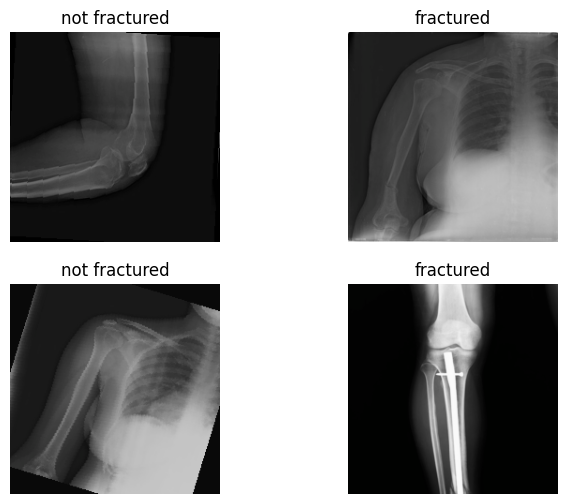

In [16]:
# Function to denormalize (undo ImageNet normalization for display)
def denormalize(img_tensor):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std  = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.numpy().transpose((1, 2, 0))   # CHW -> HWC
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Function to show a batch of images
def show_batch(dataloader, dataset, n=6):
    images, labels = next(iter(dataloader))
    class_names = dataset.dataset.classes  # ['fractured', 'not fractured']

    plt.figure(figsize=(8, 6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        img = denormalize(images[i].cpu())
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# show some training images
show_batch(dl_train, train_dataset, n=4)

Train the model

In [17]:
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
from robustbench.utils import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load pretrained model
model = load_model(
    model_name='Rade2021Helper_extra',
    dataset='cifar10',
    threat_model='Linf'
)

# 2) Replace the final Linear head with a 2-class MLP
def find_last_linear(m: nn.Module):
    last_name, last_linear = None, None
    for name, mod in m.named_modules():
        if isinstance(mod, nn.Linear):
            last_name, last_linear = name, mod
    if last_linear is None:
        raise RuntimeError("No Linear classifier found to replace.")
    return last_name, last_linear

def set_by_name(root: nn.Module, dotted: str, new_module: nn.Module):
    parts = dotted.split(".")
    parent = root
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_module)

last_name, last_linear = find_last_linear(model)
in_features = last_linear.in_features

new_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # logits for 2 classes
)
set_by_name(model, last_name, new_head)

# 3) Freeze backbone; train only the new head
for p in model.parameters():
    p.requires_grad = False
for p in new_head.parameters():
    p.requires_grad = True

# 4) Monkey-patch forward to use adaptive GAP (no image resizing needed)
#    This targets RobustBench's NormalizedWideResNet (dm_wide_resnet).
def patch_forward_if_wrn_like(m: nn.Module):
    needed = all(hasattr(m, x) for x in [
        "padding", "mean", "std", "init_conv", "layer", "batchnorm", "relu", "num_channels", "logits"
    ])
    if not needed:
        return  # model isn't that class; leave it unchanged

    def new_forward(self, x):
        # match original normalization logic/device handling
        if getattr(self, "padding", 0) > 0:
            x = F.pad(x, (self.padding,) * 4)
        if x.is_cuda:
            if getattr(self, "mean_cuda", None) is None:
                self.mean_cuda = self.mean.cuda()
                self.std_cuda = self.std.cuda()
            out = (x - self.mean_cuda) / self.std_cuda
        else:
            out = (x - self.mean) / self.std

        out = self.init_conv(out)
        out = self.layer(out)
        out = self.relu(self.batchnorm(out))

        # key change: global adaptive pooling instead of fixed 8x8
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), self.num_channels)  # (N, C)

        return self.logits(out)

    m.forward = types.MethodType(new_forward, m)

patch_forward_if_wrn_like(model)

# 5) Move everything to device; keep backbone eval, head train
model = model.to(device)

Downloading...
From (original): https://drive.google.com/uc?id=1GhAp-0C3ONRy9BxIe0J9vKc082vHvR7t
From (redirected): https://drive.google.com/uc?id=1GhAp-0C3ONRy9BxIe0J9vKc082vHvR7t&confirm=t&uuid=51051aec-19a6-464d-8e07-8f8c7a3d3059
To: /kaggle/working/xAI/models/cifar10/Linf/Rade2021Helper_extra.pt
100%|██████████| 185M/185M [00:02<00:00, 81.6MB/s] 


In [18]:
# -------------------------
# Handle Class Imbalance
# -------------------------
# (Handled by oversampling, no need for loss weights)
criterion = nn.CrossEntropyLoss()

# -------------------------
# Optimizer
# -------------------------
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [20]:
# -------------------------
# Training Loop with Best Model Saving
# -------------------------
def train_model(model, criterion, optimizer, num_epochs=15, save_path="best_helper-wrn_34_10.pth", patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        stop_training = False

        # Each epoch has training + validation
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = dl_train
            else:
                model.eval()
                dataloader = dl_val

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            it = tqdm(dataloader, desc=f"{phase} Epoch {epoch+1}/{num_epochs}")

            for inputs, labels in dataloader:
                # Ensure inputs are on the same device as the model
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                # Update tqdm postfix with current loss and acc
                it.set_postfix(loss=(running_loss/total_samples),
                               acc=(running_corrects.double()/total_samples))

                it.update(1)

            it.close()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Check for improvement
            if phase == "val":
                if epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, save_path)
                    print(f"✅ Best model updated and saved at {save_path}")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)")

                # Early stopping
                if epochs_no_improve >= patience:
                    print(f"⏹️ Early stopping triggered (no improvement for {patience} epochs).")
                    stop_training = True

        if stop_training:
            break

    print(f"\nBest val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [21]:
# -------------------------
# Run Training
# -------------------------
trained_model = train_model(model, criterion, optimizer, num_epochs=15, patience=5)


Epoch 1/15


train Epoch 1/15: 100%|██████████| 222/222 [02:00<00:00,  1.85it/s, acc=tensor(0.7558, device='cuda:0', dtype=torch.float64), loss=0.508]


train Loss: 0.5077 Acc: 0.7558


val Epoch 1/15: 100%|██████████| 28/28 [00:14<00:00,  1.94it/s, acc=tensor(0.8829, device='cuda:0', dtype=torch.float64), loss=0.324]


val Loss: 0.3243 Acc: 0.8829
✅ Best model updated and saved at best_helper-wrn_34_10.pth

Epoch 2/15


train Epoch 2/15: 100%|██████████| 222/222 [02:01<00:00,  1.83it/s, acc=tensor(0.8212, device='cuda:0', dtype=torch.float64), loss=0.395]


train Loss: 0.3955 Acc: 0.8212


val Epoch 2/15: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s, acc=tensor(0.8604, device='cuda:0', dtype=torch.float64), loss=0.321]


val Loss: 0.3209 Acc: 0.8604
⚠️ No improvement for 1 epoch(s)

Epoch 3/15


train Epoch 3/15: 100%|██████████| 222/222 [01:58<00:00,  1.87it/s, acc=tensor(0.8364, device='cuda:0', dtype=torch.float64), loss=0.394]


train Loss: 0.3941 Acc: 0.8364


val Epoch 3/15: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s, acc=tensor(0.9234, device='cuda:0', dtype=torch.float64), loss=0.208]


val Loss: 0.2083 Acc: 0.9234
✅ Best model updated and saved at best_helper-wrn_34_10.pth

Epoch 4/15


train Epoch 4/15: 100%|██████████| 222/222 [01:59<00:00,  1.85it/s, acc=tensor(0.8223, device='cuda:0', dtype=torch.float64), loss=0.381]


train Loss: 0.3807 Acc: 0.8223


val Epoch 4/15: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s, acc=tensor(0.8919, device='cuda:0', dtype=torch.float64), loss=0.255]


val Loss: 0.2552 Acc: 0.8919
⚠️ No improvement for 1 epoch(s)

Epoch 5/15


train Epoch 5/15: 100%|██████████| 222/222 [02:02<00:00,  1.81it/s, acc=tensor(0.8353, device='cuda:0', dtype=torch.float64), loss=0.383]


train Loss: 0.3829 Acc: 0.8353


val Epoch 5/15: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s, acc=tensor(0.9054, device='cuda:0', dtype=torch.float64), loss=0.276]


val Loss: 0.2755 Acc: 0.9054
⚠️ No improvement for 2 epoch(s)

Epoch 6/15


train Epoch 6/15: 100%|██████████| 222/222 [02:00<00:00,  1.84it/s, acc=tensor(0.8443, device='cuda:0', dtype=torch.float64), loss=0.352]


train Loss: 0.3516 Acc: 0.8443


val Epoch 6/15: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s, acc=tensor(0.9054, device='cuda:0', dtype=torch.float64), loss=0.237]


val Loss: 0.2372 Acc: 0.9054
⚠️ No improvement for 3 epoch(s)

Epoch 7/15


train Epoch 7/15: 100%|██████████| 222/222 [02:00<00:00,  1.84it/s, acc=tensor(0.8432, device='cuda:0', dtype=torch.float64), loss=0.37] 


train Loss: 0.3700 Acc: 0.8432


val Epoch 7/15: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s, acc=tensor(0.9324, device='cuda:0', dtype=torch.float64), loss=0.214]


val Loss: 0.2138 Acc: 0.9324
✅ Best model updated and saved at best_helper-wrn_34_10.pth

Epoch 8/15


train Epoch 8/15: 100%|██████████| 222/222 [01:59<00:00,  1.86it/s, acc=tensor(0.8342, device='cuda:0', dtype=torch.float64), loss=0.389]


train Loss: 0.3893 Acc: 0.8342


val Epoch 8/15: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s, acc=tensor(0.9144, device='cuda:0', dtype=torch.float64), loss=0.221]


val Loss: 0.2210 Acc: 0.9144
⚠️ No improvement for 1 epoch(s)

Epoch 9/15


train Epoch 9/15: 100%|██████████| 222/222 [02:00<00:00,  1.85it/s, acc=tensor(0.8460, device='cuda:0', dtype=torch.float64), loss=0.352]


train Loss: 0.3515 Acc: 0.8460


val Epoch 9/15: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s, acc=tensor(0.9459, device='cuda:0', dtype=torch.float64), loss=0.174] 


val Loss: 0.1743 Acc: 0.9459
✅ Best model updated and saved at best_helper-wrn_34_10.pth

Epoch 10/15


train Epoch 10/15: 100%|██████████| 222/222 [02:00<00:00,  1.84it/s, acc=tensor(0.8370, device='cuda:0', dtype=torch.float64), loss=0.369]


train Loss: 0.3695 Acc: 0.8370


val Epoch 10/15: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s, acc=tensor(0.8874, device='cuda:0', dtype=torch.float64), loss=0.257]


val Loss: 0.2570 Acc: 0.8874
⚠️ No improvement for 1 epoch(s)

Epoch 11/15


train Epoch 11/15: 100%|██████████| 222/222 [02:01<00:00,  1.83it/s, acc=tensor(0.8376, device='cuda:0', dtype=torch.float64), loss=0.379]


train Loss: 0.3789 Acc: 0.8376


val Epoch 11/15: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s, acc=tensor(0.9189, device='cuda:0', dtype=torch.float64), loss=0.216]


val Loss: 0.2163 Acc: 0.9189
⚠️ No improvement for 2 epoch(s)

Epoch 12/15


train Epoch 12/15: 100%|██████████| 222/222 [02:00<00:00,  1.85it/s, acc=tensor(0.8691, device='cuda:0', dtype=torch.float64), loss=0.32] 


train Loss: 0.3196 Acc: 0.8691


val Epoch 12/15: 100%|██████████| 28/28 [00:14<00:00,  1.94it/s, acc=tensor(0.9099, device='cuda:0', dtype=torch.float64), loss=0.226]


val Loss: 0.2263 Acc: 0.9099
⚠️ No improvement for 3 epoch(s)

Epoch 13/15


train Epoch 13/15: 100%|██████████| 222/222 [02:01<00:00,  1.83it/s, acc=tensor(0.8782, device='cuda:0', dtype=torch.float64), loss=0.3]  


train Loss: 0.2999 Acc: 0.8782


val Epoch 13/15: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s, acc=tensor(0.9234, device='cuda:0', dtype=torch.float64), loss=0.198]


val Loss: 0.1983 Acc: 0.9234
⚠️ No improvement for 4 epoch(s)

Epoch 14/15


train Epoch 14/15: 100%|██████████| 222/222 [02:01<00:00,  1.82it/s, acc=tensor(0.8584, device='cuda:0', dtype=torch.float64), loss=0.342]


train Loss: 0.3423 Acc: 0.8584


val Epoch 14/15: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s, acc=tensor(0.9550, device='cuda:0', dtype=torch.float64), loss=0.176]


val Loss: 0.1764 Acc: 0.9550
✅ Best model updated and saved at best_helper-wrn_34_10.pth

Epoch 15/15


train Epoch 15/15: 100%|██████████| 222/222 [01:59<00:00,  1.86it/s, acc=tensor(0.8472, device='cuda:0', dtype=torch.float64), loss=0.341]


train Loss: 0.3406 Acc: 0.8472


val Epoch 15/15: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s, acc=tensor(0.9279, device='cuda:0', dtype=torch.float64), loss=0.199]

val Loss: 0.1987 Acc: 0.9279
⚠️ No improvement for 1 epoch(s)

Best val Acc: 0.9550


In [23]:
# -------------------------
# Upload the best model to huggingface
# -------------------------
# Get token and login
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
login(token=hf_token)
print("✅ Logged in to Hugging Face")

# Create the repository first (only needed once)
repo_id = "MohammadFazli/xAI-fracture-xray-model"
try:
    create_repo(
        repo_id=repo_id,
        token=hf_token,
        private=False,  # Set to True if you want a private repo
        repo_type="model"
    )
    print(f"✅ Repository created: {repo_id}")
except Exception as e:
    print(f"ℹ️  Repository might already exist: {e}")

# Save model (uncomment if not already saved)
local_path = "/kaggle/working/xAI/best_helper-wrn_34_10.pth"
# torch.save(model.state_dict(), local_path)

# Verify file exists
if not os.path.exists(local_path):
    raise FileNotFoundError(f"Model file not found at: {local_path}")
else:
    file_size = os.path.getsize(local_path) / (1024 * 1024)  # MB
    print(f"✅ Model file found: {file_size:.2f} MB")

# Upload to Hugging Face
print("📤 Uploading to Hugging Face...")
api = HfApi()
api.upload_file(
    path_or_fileobj=local_path,
    path_in_repo="best_helper_wrn_34_10.pth",
    repo_id=repo_id,
    repo_type="model",
    token=hf_token
)

print("✅ Model uploaded to Hugging Face Hub!")
print(f"🔗 Access at: https://huggingface.co/{repo_id}")

✅ Logged in to Hugging Face
ℹ️  Repository might already exist: Client error '409 Conflict' for url 'https://huggingface.co/api/repos/create' (Request ID: Root=1-68efa52a-559c8abf376ee97370043ac1;15170705-0c71-4e1c-b375-51dda356037e)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/409

You already created this model repo: MohammadFazli/xAI-fracture-xray-model
✅ Model file found: 177.48 MB
📤 Uploading to Hugging Face...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Model uploaded to Hugging Face Hub!
🔗 Access at: https://huggingface.co/MohammadFazli/xAI-fracture-xray-model


Evaluation

In [24]:
# ================================
# Eval: RobustBench + 2-class head
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base = load_model(
    model_name='Rade2021Helper_extra',
    dataset='cifar10',
    threat_model='Linf'
)

# --- replace final Linear with 2-class MLP (same as training) ---
def find_last_linear(m: nn.Module):
    last_name, last_linear = None, None
    for name, mod in m.named_modules():
        if isinstance(mod, nn.Linear):
            last_name, last_linear = name, mod
    if last_linear is None:
        raise RuntimeError("No Linear classifier found to replace.")
    return last_name, last_linear

def set_by_name(root: nn.Module, dotted: str, new_module: nn.Module):
    parts = dotted.split(".")
    parent = root
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_module)

last_name, last_linear = find_last_linear(base)
in_features = last_linear.in_features

new_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)
set_by_name(base, last_name, new_head)

# IMPORTANT: do NOT register the head again as a Module attribute.
# If you want a handle, save the *name* instead (a plain string is safe).
base._head_name = last_name  # string, not an nn.Module

# --- monkey-patch forward for adaptive GAP (no resizing) ---
def maybe_patch_dm_wrn_forward(m: nn.Module):
    needed = all(hasattr(m, x) for x in
                 ["padding", "mean", "std", "init_conv", "layer", "batchnorm", "relu", "num_channels", "logits"])
    if not needed:
        return

    def new_forward(self, x):
        if getattr(self, "padding", 0) > 0:
            x = F.pad(x, (self.padding,) * 4)
        if x.is_cuda:
            if getattr(self, "mean_cuda", None) is None:
                self.mean_cuda = self.mean.cuda()
                self.std_cuda = self.std.cuda()
            out = (x - self.mean_cuda) / self.std_cuda
        else:
            out = (x - self.mean) / self.std
        out = self.init_conv(out)
        out = self.layer(out)
        out = self.relu(self.batchnorm(out))
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), self.num_channels)
        return self.logits(out)

    m.forward = types.MethodType(new_forward, m)

maybe_patch_dm_wrn_forward(base)

# --- load fine-tuned weights
checkpoint_path = "/kaggle/working/xAI/best_helper-wrn_34_10.pth"
state = torch.load(checkpoint_path, map_location="cpu")
base.load_state_dict(state, strict=True)

model = base.to(device).eval()
print(f"✅ Loaded fine-tuned weights from: {checkpoint_path}")

✅ Loaded fine-tuned weights from: /kaggle/working/xAI/best_helper-wrn_34_10.pth


In [25]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion=None, class_names=None, device=None):
    model.eval()
    all_labels, all_preds = [], []
    total_samples, running_loss = 0, 0.0

    for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        if criterion is not None:
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        total_samples += labels.size(0)

    all_labels, all_preds = np.array(all_labels), np.array(all_preds)
    acc = (all_preds == all_labels).mean() * 100
    avg_loss = running_loss / total_samples if criterion else None

    print("========================================")
    print(f"✅ Test Accuracy: {acc:.2f}%")
    if avg_loss is not None:
        print(f"💡 Average Loss: {avg_loss:.4f}")
    print("========================================")

    if class_names:
        print("\n📊 Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        print("🔢 Confusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))
        # -------------------------
    
    return acc, all_preds, all_labels

# Run evaluation
criterion = nn.CrossEntropyLoss()
class_names = ["fractured", "not fractured"]

test_acc, y_pred, y_true = evaluate_model(
    model,
    dataloader=dl_test,
    criterion=criterion,
    class_names=class_names,
    device=device,
)

✅ Test Accuracy: 96.40%
💡 Average Loss: 0.1637

📊 Classification Report:
               precision    recall  f1-score   support

    fractured       0.93      0.96      0.95        72
not fractured       0.98      0.97      0.97       150

     accuracy                           0.96       222
    macro avg       0.96      0.96      0.96       222
 weighted avg       0.96      0.96      0.96       222

🔢 Confusion Matrix:
[[ 69   3]
 [  5 145]]


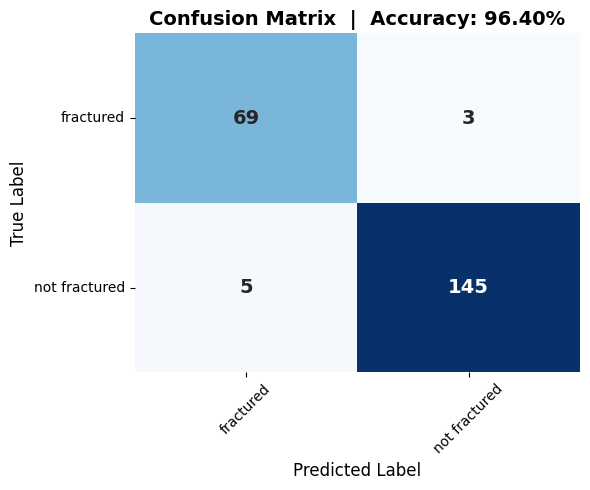

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
acc = (y_true == y_pred).mean() * 100

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False,
    annot_kws={"size": 14, "weight": "bold"}
)
plt.title(f"Confusion Matrix  |  Accuracy: {acc:.2f}%", fontsize=14, weight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Attack

In [27]:
# ---------------------------
# DataLoaders
# ---------------------------
batch_size = 1
ImageFile.LOAD_TRUNCATED_IMAGES = True

dl_test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Test: {len(test_dataset)}")

Test: 222


In [28]:
eps = 4/255.0        # L_inf epsilon
alpha = 1/255.0      # step size
steps = 10            # PGD steps
random_start = True  # random init inside L_inf ball

# CIFAR-10 normalization statistics (what your model expects)
CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
CIFAR_STD = torch.tensor([0.2470, 0.2435, 0.2616])

# ---------- Helpers ----------
def _maybe_repeat_to_three(x):
    """If input has 1 channel, repeat to 3 channels (model expects 3)."""
    if x.dim() == 4 and x.size(1) == 1:
        return x.repeat(1, 3, 1, 1)
    return x

def pgd_linf_batch_simple(model, x_orig, y, eps, alpha, steps, random_start=True):
    """
    PGD attack for normalized images.
    x_orig: [B,C,H,W] - NORMALIZED images (using CIFAR-10 normalization)
    y: [B] long labels
    returns x_adv: adversarial examples in normalized space
    """
    device = x_orig.device
    
    # Get normalization parameters
    mean = CIFAR_MEAN.view(1, 3, 1, 1).to(device)
    std = CIFAR_STD.view(1, 3, 1, 1).to(device)
    
    # Calculate valid range in normalized space
    # (0 - mean) / std  to  (1 - mean) / std
    lower_limit = (0 - mean) / std
    upper_limit = (1 - mean) / std
    
    # Handle single-channel images
    if x_orig.size(1) == 1:
        lower_limit = lower_limit[:, 0:1, :, :]
        upper_limit = upper_limit[:, 0:1, :, :]
    
    x_orig = x_orig.detach()
    
    if random_start:
        x_adv = x_orig + torch.empty_like(x_orig).uniform_(-eps, eps)
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    else:
        x_adv = x_orig.clone().detach()
    
    loss_fn = nn.CrossEntropyLoss()
    
    for _ in range(steps):
        x_adv.requires_grad_()
        xin = _maybe_repeat_to_three(x_adv)
        logits = model(xin)
        loss = loss_fn(logits, y)
        
        model.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.data.zero_()
        loss.backward()
        
        grad = x_adv.grad.detach()
        x_adv = x_adv.detach() + alpha * torch.sign(grad)
        
        # Project to L_inf ball around original
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        
        # Clamp to valid normalized range (not [0,1]!)
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    
    return x_adv.detach()

In [29]:
def denormalize(img_tensor):
    """
    Denormalize image tensor using dataset mean/std (ImageNet or your dataset)
    img_tensor: [C,H,W] in torch tensor
    returns: [H,W,C] numpy in [0,1]
    """
    mean = np.array([0.4914, 0.4822, 0.4465])
    std  = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.numpy().transpose((1,2,0))  # CHW -> HWC
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_before_after(orig_batch, adv_batch, y_true, y_pred, class_names=None, n=6, figsize_per_img=(3,3)):
    """
    Display original, adversarial, and perturbation images in three rows.
    - orig_batch, adv_batch: torch tensors [B, C, H, W] in normalized form
    - y_true, y_pred: arrays/lists of labels (numeric)
    - class_names: list of class names (index -> name). If None, numeric labels are used.
    - n: number of samples to show (from start of batch)
    - figsize_per_img: tuple (width, height) in inches per image
    """
    # Convert to numpy
    if isinstance(orig_batch, torch.Tensor):
        orig = orig_batch.cpu().numpy()
    else:
        orig = np.array(orig_batch)
    if isinstance(adv_batch, torch.Tensor):
        adv = adv_batch.cpu().numpy()
    else:
        adv = np.array(adv_batch)

    B = orig.shape[0]
    n = min(n, B)
    w, h = figsize_per_img
    plt.figure(figsize=(n * w, h * 3))  # 3 rows, n columns

    for i in range(n):
        # --- Original (top row) ---
        ax = plt.subplot(3, n, i + 1)
        img_o = denormalize(torch.tensor(orig[i]))
        ax.imshow(img_o)
        true_label = (class_names[y_true[i]] if class_names is not None else str(y_true[i]))
        ax.set_title(f"Orig (t={true_label})", fontsize=10)
        ax.axis("off")

        # --- Adversarial (middle row) ---
        ax = plt.subplot(3, n, n + i + 1)
        img_a = denormalize(torch.tensor(adv[i]))
        ax.imshow(img_a)
        pred_label = (class_names[y_pred[i]] if class_names is not None else str(y_pred[i]))
        ax.set_title(f"Adv (p={pred_label})", fontsize=10)
        ax.axis("off")

        # --- Perturbation (bottom row) ---
        pert = img_a - img_o
        pert_min, pert_max = pert.min(), pert.max()
        pert_vis = np.where(pert_max != pert_min,
                            (pert - pert_min) / (pert_max - pert_min),
                            0.5)
        ax2 = plt.subplot(3, n, 2 * n + i + 1)
        ax2.imshow(pert_vis)
        ax2.set_title("Perturbation (Scaled)", fontsize=10)
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

In [31]:
# ---------- Run attack on dl_test and collect preds/labels ----------
model.eval()

all_adv_preds = []
all_adv_labels = []

for inputs, labels in tqdm(dl_test, desc=f"PGD eps={eps} steps={steps}"):
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)

    # Make adversarial examples for this batch
    x_adv = pgd_linf_batch_simple(model, inputs, labels, eps=eps, alpha=alpha, steps=steps, random_start=random_start)

    # Evaluate on adversarial examples
    with torch.no_grad():
        logits_adv = model(_maybe_repeat_to_three(x_adv))
        preds_adv = torch.argmax(logits_adv, dim=1)

    all_adv_preds.append(preds_adv.cpu().numpy())
    all_adv_labels.append(labels.cpu().numpy())

    del inputs, labels, x_adv, logits_adv, preds_adv
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Concatenate results
all_adv_preds = np.concatenate(all_adv_preds)
all_adv_labels = np.concatenate(all_adv_labels)

PGD eps=0.01568627450980392 steps=10: 100%|██████████| 222/222 [09:14<00:00,  2.50s/it]



=== Adversarial test set metrics (PGD L_inf eps=0.01568627450980392, steps=10) ===
Accuracy: 0.5946

Classification report (per-class + macro & weighted):
               precision    recall  f1-score   support

    fractured     0.4250    0.7083    0.5312        72
not fractured     0.7941    0.5400    0.6429       150

     accuracy                         0.5946       222
    macro avg     0.6096    0.6242    0.5871       222
 weighted avg     0.6744    0.5946    0.6067       222


Confusion matrix (rows=true, cols=pred):
[[51 21]
 [69 81]]


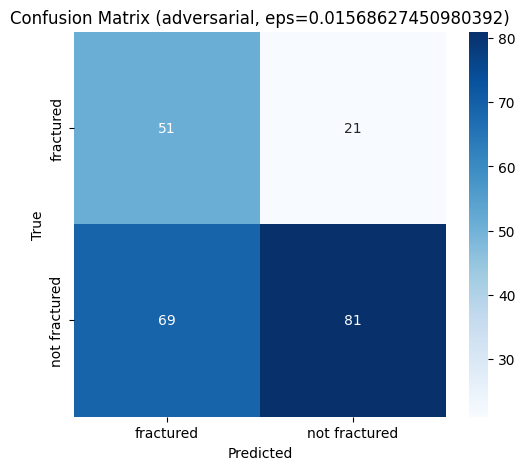


Macro-avg: precision=0.6096, recall=0.6242, f1=0.5871
Weighted-avg: precision=0.6744, recall=0.5946, f1=0.6067


In [32]:
# ---------- Compute & print metrics ----------
class_names = train_dataset.dataset.classes if hasattr(train_dataset, "dataset") else ['fractured', 'not fractured']
acc = accuracy_score(all_adv_labels, all_adv_preds)
report_dict = classification_report(all_adv_labels, all_adv_preds, target_names=class_names, digits=4, output_dict=True)
report_str = classification_report(all_adv_labels, all_adv_preds, target_names=class_names, digits=4)
cm = confusion_matrix(all_adv_labels, all_adv_preds)

print(f"\n=== Adversarial test set metrics (PGD L_inf eps={eps}, steps={steps}) ===")
print(f"Accuracy: {acc:.4f}\n")
print("Classification report (per-class + macro & weighted):")
print(report_str)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

# Confusion heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (adversarial, eps={eps})")
plt.show()

# Macro & weighted scores
macro_p = report_dict['macro avg']['precision']
macro_r = report_dict['macro avg']['recall']    
macro_f1 = report_dict['macro avg']['f1-score']
w_p = report_dict['weighted avg']['precision']
w_r = report_dict['weighted avg']['recall']
w_f1 = report_dict['weighted avg']['f1-score']

print(f"\nMacro-avg: precision={macro_p:.4f}, recall={macro_r:.4f}, f1={macro_f1:.4f}")
print(f"Weighted-avg: precision={w_p:.4f}, recall={w_r:.4f}, f1={w_f1:.4f}")

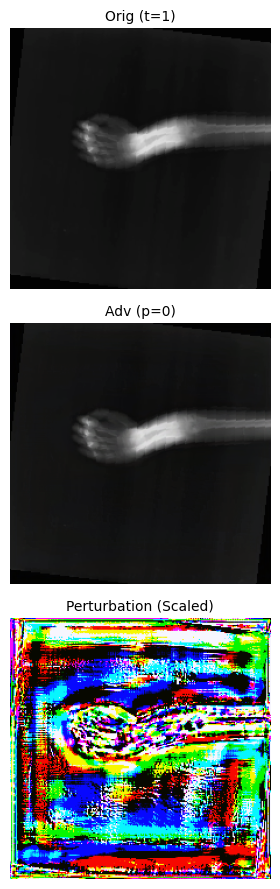

In [33]:
# -------------------------
# Example usage with one batch
# -------------------------
# get one small batch
inputs, labels = next(iter(dl_test))
# create adversarial batch (small n, e.g. steps=1)
x_adv = pgd_linf_batch_simple(model, inputs.to(device), labels.to(device), eps=eps, alpha=alpha, steps=steps, random_start=random_start)
with torch.no_grad():
    logits_adv = model(_maybe_repeat_to_three(x_adv))
    preds = torch.argmax(logits_adv, dim=1).cpu().numpy()

# choose class names from test dataset if available
class_names = test_dataset.classes if hasattr(test_dataset, "classes") else None

# show first 6 examples (or change n)
show_before_after(inputs, x_adv.cpu(), labels.numpy(), preds, class_names=class_names, n=6, figsize_per_img=(3.0, 3.0))

Interpretability

In [34]:
class_names = ["fractured", "not fractured"]

# Clean and recreate output directories
shutil.rmtree(write_dir, ignore_errors=True)
for cls in class_names:
    os.makedirs(os.path.join(write_dir, cls, "img"), exist_ok=True)
    os.makedirs(os.path.join(write_dir, cls, "ann"), exist_ok=True)

# ---------------------------
# Collect fractured images + annotations from train/test/val
# ---------------------------
fractured_imgs, fractured_anns = [], []
for subdir in ["train", "test", "val"]:
    img_dir = os.path.join(data_root, subdir, "img")
    ann_dir = os.path.join(data_root, subdir, "ann")
    if os.path.exists(img_dir):
        fractured_imgs.extend([os.path.join(img_dir, x) for x in os.listdir(img_dir)])
    if os.path.exists(ann_dir):
        fractured_anns.extend([os.path.join(ann_dir, x) for x in os.listdir(ann_dir)])

print(f"Found {len(fractured_imgs)} fractured images and {len(fractured_anns)} fractured annotations")

# ---------------------------
# Collect non-fractured images + annotations
# ---------------------------
nonfractured_imgs, nonfractured_anns = [], []
nf_img_dir = os.path.join(data_root, "not fractured", "img")
nf_ann_dir = os.path.join(data_root, "not fractured", "ann")

if os.path.exists(nf_img_dir):
    nonfractured_imgs = [os.path.join(nf_img_dir, x) for x in os.listdir(nf_img_dir)]
if os.path.exists(nf_ann_dir):
    nonfractured_anns = [os.path.join(nf_ann_dir, x) for x in os.listdir(nf_ann_dir)]

print(f"Found {len(nonfractured_imgs)} non-fractured images and {len(nonfractured_anns)} non-fractured annotations")

# ---------------------------
# Optional undersampling for non-fractured
# ---------------------------
target_nonfractured = 1500
if len(nonfractured_imgs) > target_nonfractured:
    selected_imgs = random.sample(nonfractured_imgs, target_nonfractured)
    selected_img_names = set(os.path.basename(x) for x in selected_imgs)
    nonfractured_anns = [x for x in nonfractured_anns if os.path.basename(x).replace('.json', '.png') in selected_img_names]
    nonfractured_imgs = selected_imgs

print(f"Using {len(nonfractured_imgs)} non-fractured images after undersampling.")

# ---------------------------
# Copy fractured data
# ---------------------------
for img_path in fractured_imgs:
    shutil.copy(img_path, os.path.join(write_dir, "fractured", "img"))
# Copy corresponding annotations (if exists)
for ann_path in fractured_anns:
    shutil.copy(ann_path, os.path.join(write_dir, "fractured", "ann"))

# ---------------------------
# Copy non-fractured data
# ---------------------------
for img_path in nonfractured_imgs:
    shutil.copy(img_path, os.path.join(write_dir, "not fractured", "img"))
# Copy corresponding annotations (if exists)
for ann_path in nonfractured_anns:
    shutil.copy(ann_path, os.path.join(write_dir, "not fractured", "ann"))

# ---------------------------
# Final check
# ---------------------------
print("✅ Dataset prepared successfully!")
for cls in class_names:
    n_img = len(os.listdir(os.path.join(write_dir, cls, "img")))
    n_ann = len(os.listdir(os.path.join(write_dir, cls, "ann")))
    print(f"{cls:15s}: {n_img} images | {n_ann} annotations")

Found 717 fractured images and 717 fractured annotations
Found 3366 non-fractured images and 3366 non-fractured annotations
Using 1500 non-fractured images after undersampling.
✅ Dataset prepared successfully!
fractured      : 717 images | 717 annotations
not fractured  : 1500 images | 0 annotations


In [35]:
# ---------------------------
# Transforms
# ---------------------------
# Standard normalization
normalize_transform = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2470, 0.2435, 0.2616]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize_transform
])

In [36]:
class FracturedDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, os.path.splitext(img_name)[0] + ".jpg.json")

        # Load image
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        # Load annotation
        with open(ann_path, "r") as f:
            ann = json.load(f)

        # Get rectangle coordinates
        rects = []
        for obj in ann.get("objects", []):
            if obj.get("geometryType") == "rectangle":
                (x1, y1), (x2, y2) = obj["points"]["exterior"]
                rects.append([x1, y1, x2, y2])

        # Compute scale factors
        new_w, new_h = 224, 224
        scale_x, scale_y = new_w / orig_w, new_h / orig_h

        # Scale the boxes
        scaled_rects = []
        for x1, y1, x2, y2 in rects:
            scaled_rects.append([
                x1 * scale_x,
                y1 * scale_y,
                x2 * scale_x,
                y2 * scale_y
            ])

        if self.transform:
            image = self.transform(image)

        return image, scaled_rects, img_name

In [37]:
dataset = FracturedDataset(
    img_dir="/kaggle/working/fracatlas/fractured/img",
    ann_dir="/kaggle/working/fracatlas/fractured/ann",
    transform=transform
)

# Evaluate on a subset of dataset
subset_indices = list(range(10))
subset_dataset = Subset(dataset, subset_indices)

In [38]:
def compute_saliency_map(image, model, target_class):
    """Compute saliency map (gradient-based)."""
    image.requires_grad = True
    output = model(image)
    score = output[0, target_class]
    if image.grad is not None:
        image.grad.zero_()
    score.backward()
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    return saliency.squeeze().detach().cpu().numpy()


def compute_integrated_gradients(image, model, target_class, steps=10):
    """
    Compute Integrated Gradients map with TILE-BASED processing.
    This splits the image into smaller tiles to reduce memory usage.
    """
    device = image.device
    _, _, h, w = image.shape
    
    # Process image in tiles to reduce memory
    tile_size = 112  # Half of 224 - adjust based on your GPU memory
    stride = tile_size  # No overlap for simplicity
    
    # Initialize full saliency map
    full_saliency = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    # Process each tile
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            y_end = min(y + tile_size, h)
            x_end = min(x + tile_size, w)
            
            # Extract tile
            tile = image[:, :, y:y_end, x:x_end].detach().clone().requires_grad_(True)
            
            # Skip if tile is too small
            if tile.shape[2] < 32 or tile.shape[3] < 32:
                continue
            
            try:
                # Create IG instance per tile
                ig = IntegratedGradients(model)
                
                with torch.set_grad_enabled(True):
                    # Use a zero baseline
                    baseline = torch.zeros_like(tile)
                    attributions, _ = ig.attribute(
                        tile,
                        baselines=baseline,
                        target=target_class,
                        n_steps=steps,
                        return_convergence_delta=True,
                        internal_batch_size=1
                    )
                
                # Get max across channels
                tile_saliency, _ = torch.max(attributions.abs(), dim=1)
                tile_result = tile_saliency.squeeze().detach().cpu().numpy()
                
                # Add to full map
                full_saliency[y:y_end, x:x_end] += tile_result
                count_map[y:y_end, x:x_end] += 1
                
                # Aggressive cleanup
                del ig, attributions, tile_saliency, tile, baseline
                torch.cuda.empty_cache()
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"OOM on tile ({y}:{y_end}, {x}:{x_end}), skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
    
    # Average overlapping regions (if any)
    count_map[count_map == 0] = 1  # Avoid division by zero
    full_saliency = full_saliency / count_map
    
    return full_saliency


def compute_deeplift(image, model, target_class):
    """
    Compute DeepLift map with TILE-BASED processing to handle memory constraints.
    This splits the image into smaller tiles to reduce memory usage.
    """
    import warnings
    
    device = image.device
    _, _, h, w = image.shape
    
    # Process image in tiles to reduce memory
    tile_size = 112  # Half of 224 - adjust based on your GPU memory
    stride = tile_size  # No overlap for simplicity
    
    # Initialize full saliency map
    full_saliency = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    # Suppress Captum warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning, module='captum')
        
        # Process each tile
        for y in range(0, h, stride):
            for x in range(0, w, stride):
                y_end = min(y + tile_size, h)
                x_end = min(x + tile_size, w)
                
                # Extract tile
                tile = image[:, :, y:y_end, x:x_end].detach().clone()
                
                # Skip if tile is too small
                if tile.shape[2] < 32 or tile.shape[3] < 32:
                    continue
                
                try:
                    # Create DeepLift instance per tile to avoid memory accumulation
                    dl = DeepLift(model)
                    
                    with torch.set_grad_enabled(True):
                        # Use a zero baseline
                        baseline = torch.zeros_like(tile)
                        attributions = dl.attribute(tile, baselines=baseline, target=target_class)
                    
                    # Get max across channels
                    tile_saliency, _ = torch.max(attributions.abs(), dim=1)
                    tile_result = tile_saliency.squeeze().detach().cpu().numpy()
                    
                    # Add to full map
                    full_saliency[y:y_end, x:x_end] += tile_result
                    count_map[y:y_end, x:x_end] += 1
                    
                    # Aggressive cleanup
                    del dl, attributions, tile_saliency, tile, baseline
                    torch.cuda.empty_cache()
                    
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"OOM on tile ({y}:{y_end}, {x}:{x_end}), skipping...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e
    
    # Average overlapping regions (if any)
    count_map[count_map == 0] = 1  # Avoid division by zero
    full_saliency = full_saliency / count_map
    
    return full_saliency


def compute_deeplift_simple(image, model, target_class):
    """
    Simplified DeepLift with maximum memory efficiency.
    Use this if tile-based approach still has issues.
    """
    # Move to CPU if GPU has issues
    device = image.device
    
    # Detach and use zero baseline
    image_input = image.detach().clone()
    baseline = torch.zeros_like(image_input)
    
    try:
        dl = DeepLift(model)
        
        with torch.set_grad_enabled(True):
            attributions = dl.attribute(image_input, baselines=baseline, target=target_class)
        
        # Convert to numpy immediately
        saliency, _ = torch.max(attributions.abs(), dim=1)
        result = saliency.squeeze().detach().cpu().numpy()
        
        # Clean up
        del attributions, saliency, image_input, baseline, dl
        torch.cuda.empty_cache()
        gc.collect()
        
        return result
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("DeepLift OOM even on CPU - image might be too large")
            # Return zeros as fallback
            return np.zeros(image.shape[2:], dtype=np.float32)
        else:
            raise e


def compute_occlusion(image, model, target_class, sliding_window=15, stride=8):
    """
    Compute Occlusion attribution map using Captum.
    Uses sliding window occlusion over the image.
    """
    device = image.device
    try:
        occlusion = Occlusion(model)

        with torch.set_grad_enabled(True):
            # Define window shape same as image channels
            attributions = occlusion.attribute(
                image,
                strides=(3, stride, stride),
                target=target_class,
                sliding_window_shapes=(3, sliding_window, sliding_window),
                baselines=0
            )

        saliency, _ = torch.max(attributions.abs(), dim=1)
        result = saliency.squeeze().detach().cpu().numpy()

        del occlusion, attributions, saliency
        torch.cuda.empty_cache()
        gc.collect()

        return result

    except RuntimeError as e:
        if "out of memory" in str(e):
            print("Occlusion OOM - try smaller sliding_window or stride.")
            return np.zeros(image.shape[2:], dtype=np.float32)
        else:
            raise e

def compute_point_coverage(model, dataset, method='saliency', device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95],
                          use_tile_deeplift=True):
    """
    Compute only Point Coverage metric for a chosen attribution method.
    
    Args:
        model: PyTorch model
        dataset: dataset with (image, boxes, img_name)
        method: 'saliency', 'integrated_gradients', or 'deeplift'
        device: device to run on
        percentiles: list of percentile thresholds for saliency
        use_tile_deeplift: if True, use tile-based DeepLift (recommended for memory)
    """
    model.eval()

    attribution_methods = {
        'saliency': compute_saliency_map,
        'integrated_gradients': compute_integrated_gradients,
        'deeplift': compute_deeplift if use_tile_deeplift else compute_deeplift_simple,
        'occlusion': compute_occlusion
    }

    # Use GPU for all methods now
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if method not in attribution_methods:
        raise ValueError(f"Invalid method '{method}'. Choose from {list(attribution_methods.keys())}.")

    coverage_results = {p: [] for p in percentiles}

    pbar = tqdm(range(len(dataset)), desc=f"Computing Point Coverage ({method})")

    for idx in pbar:
        image, boxes, img_name = dataset[idx]
        image = image.unsqueeze(0).to(device)

        # Use no_grad for forward pass
        with torch.no_grad():
            output = model(image)
            pred_class = output.argmax(dim=1).item()

        # Create ground-truth mask
        gt_mask = np.zeros(image.shape[2:], dtype=np.uint8)
        for (x1, y1, x2, y2) in boxes:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(gt_mask.shape[1], x2), min(gt_mask.shape[0], y2)
            gt_mask[y1:y2, x1:x2] = 1
        if np.sum(gt_mask) == 0:
            continue

        # Compute chosen attribution map
        func = attribution_methods[method]
        try:
            # For saliency, we need a fresh clone with gradients
            if method == 'saliency':
                input_img = image.clone().requires_grad_(True)
            else:
                input_img = image
                
            saliency = func(input_img, model, pred_class)
            
            # Clear gradients immediately after attribution
            if hasattr(input_img, 'grad') and input_img.grad is not None:
                input_img.grad = None
            del input_img
            
        except Exception as e:
            print(f"[{method}] failed for {img_name}: {e}")
            continue

        # Evaluate point coverage at each percentile
        for percentile in percentiles:
            threshold = np.percentile(saliency, 100 - percentile)
            saliency_mask = (saliency >= threshold).astype(np.uint8)

            intersection_points = np.sum((gt_mask == 1) & (saliency_mask == 1))
            total_gt_points = np.sum(gt_mask)
            point_coverage = intersection_points / total_gt_points if total_gt_points > 0 else 0
            coverage_results[percentile].append(point_coverage)

        # Aggressive cleanup after each image
        del image, saliency, gt_mask, output
        torch.cuda.empty_cache()
        gc.collect()
        
        # Optional: print memory usage periodically
        if idx % 50 == 0 and torch.cuda.is_available():
            pbar.set_postfix({'GPU_MB': f"{torch.cuda.memory_allocated() / 1024**2:.0f}"})

    # Compute average point coverage per percentile
    avg_results = {p: np.mean(vals) if vals else 0 for p, vals in coverage_results.items()}
    pbar.close()
    return coverage_results, avg_results


def print_point_coverage_results(avg_results, method):
    """Print Point Coverage results for the selected method."""
    print(f"\n{'='*60}\n{method.upper()} POINT COVERAGE RESULTS\n{'='*60}")
    print(f"{'Percentile':<12} {'Point Coverage (%)':<20}")
    print("-" * 60)
    for p, val in avg_results.items():
        print(f"{p:<12} {val * 100:>8.2f}%")


def evaluate_point_coverage(model, dataset, method='saliency', model_name="Model"):
    """Full pipeline for computing and printing Point Coverage."""
    print(f"\nEvaluating {model_name} using {method} method...")
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    detailed_results, avg_results = compute_point_coverage(
        model, dataset, method=method, device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95]
    )
    print_point_coverage_results(avg_results, method)
    return detailed_results, avg_results

In [40]:
detailed_results, avg_results = evaluate_point_coverage(
    model,
    dataset,
    method='saliency',
    model_name="Helper-Based"
)


Evaluating Helper-Based using saliency method...


Computing Point Coverage (saliency): 100%|██████████| 717/717 [07:19<00:00,  1.63it/s, GPU_MB=557]


SALIENCY POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5               13.74%
15              29.55%
25              39.78%
50              59.40%
75              76.90%
85              84.47%
95              93.78%


In [41]:
detailed_results, avg_results = evaluate_point_coverage(
    model,
    dataset,
    method='deeplift',
    model_name="Helper-Based"
)


Evaluating Helper-Based using deeplift method...


Computing Point Coverage (deeplift): 100%|██████████| 717/717 [08:31<00:00,  1.40it/s, GPU_MB=557]


DEEPLIFT POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5                2.61%
15               7.68%
25              12.58%
50              26.69%
75              46.65%
85              59.12%
95              80.31%


In [42]:
detailed_results, avg_results = evaluate_point_coverage(
    model,
    dataset,
    method='integrated_gradients',
    model_name="Helper-Based"
)


Evaluating Helper-Based using integrated_gradients method...


Computing Point Coverage (integrated_gradients): 100%|██████████| 717/717 [25:27<00:00,  2.13s/it, GPU_MB=557]


INTEGRATED_GRADIENTS POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5                3.80%
15              11.29%
25              16.47%
50              28.91%
75              46.51%
85              58.12%
95              78.55%


In [43]:
# Visualization function
def show_attribution_with_box(model, dataset, idx, method='saliency', device='cuda'):
    """
    Visualize attribution (Saliency, Integrated Gradients, DeepLift) for a given sample.
    Automatically calls the appropriate compute_* function defined earlier.
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # --- Get sample ---
    image, boxes, name = dataset[idx]
    image = image.unsqueeze(0).to(device)

    # --- Forward pass ---
    with torch.no_grad():
        output = model(image)
        pred_class = output.argmax(dim=1).item()

    # --- Select attribution method ---
    if method == 'saliency':
        input_img = image.clone().requires_grad_(True)
        saliency = compute_saliency_map(input_img, model, pred_class)

    elif method == 'integrated_gradients':
        saliency = compute_integrated_gradients(image, model, pred_class, steps=10)

    elif method == 'deeplift':
        # We can switch to compute_deeplift_simple if GPU memory is low
        saliency = compute_deeplift(image, model, pred_class)

    elif method == 'occlusion':
        saliency = compute_occlusion(image, model, pred_class)

    else:
        raise ValueError("Invalid method. Choose from ['saliency', 'integrated_gradients', 'deeplift'].")

    # --- Convert normalized tensor back to image for visualization ---
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])],
        std=[1/s for s in [0.2470, 0.2435, 0.2616]]
    )
    img_vis = inv_normalize(image.squeeze().detach().cpu())
    img_vis = torch.clamp(img_vis, 0, 1).permute(1, 2, 0).detach().numpy()

    # --- Normalize saliency for display ---
    saliency_norm = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)

    # --- Visualization ---
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image with GT boxes
    ax[0].imshow(img_vis)
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax[0].add_patch(rect)
    ax[0].set_title(f"Original Image\n{name}")
    ax[0].axis('off')

    # Pure saliency map
    ax[1].imshow(saliency_norm, cmap='hot')
    ax[1].set_title(f"{method.title()} Map")
    ax[1].axis('off')

    # Overlay of saliency on image
    ax[2].imshow(img_vis)
    ax[2].imshow(saliency_norm, cmap='hot', alpha=0.5)
    ax[2].set_title(f"Overlay ({method.title()})")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # --- Cleanup ---
    del image, output, saliency
    torch.cuda.empty_cache()
    gc.collect()

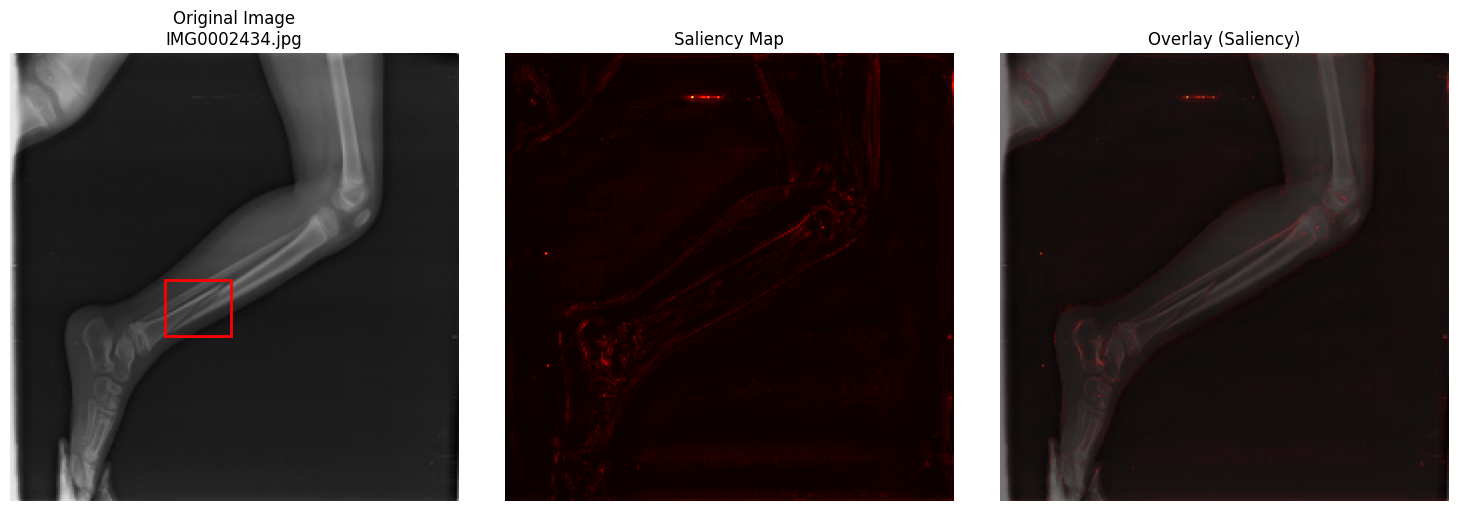

In [44]:
show_attribution_with_box(model, dataset, idx=290, method='saliency')

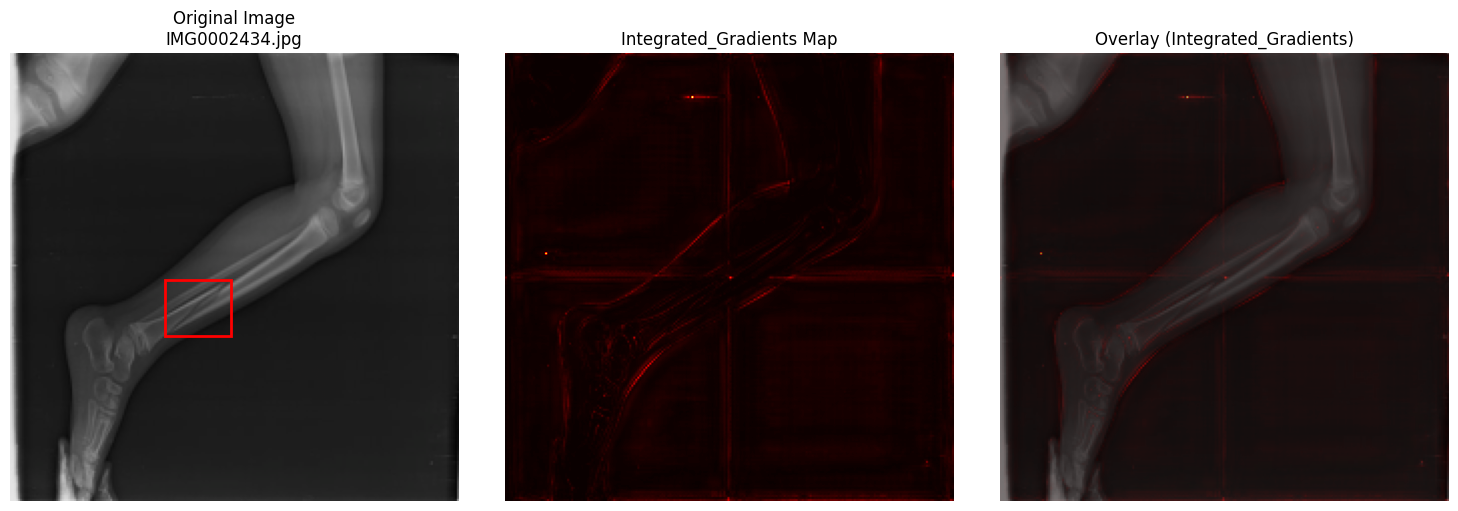

In [45]:
show_attribution_with_box(model, dataset, idx=290, method='integrated_gradients')

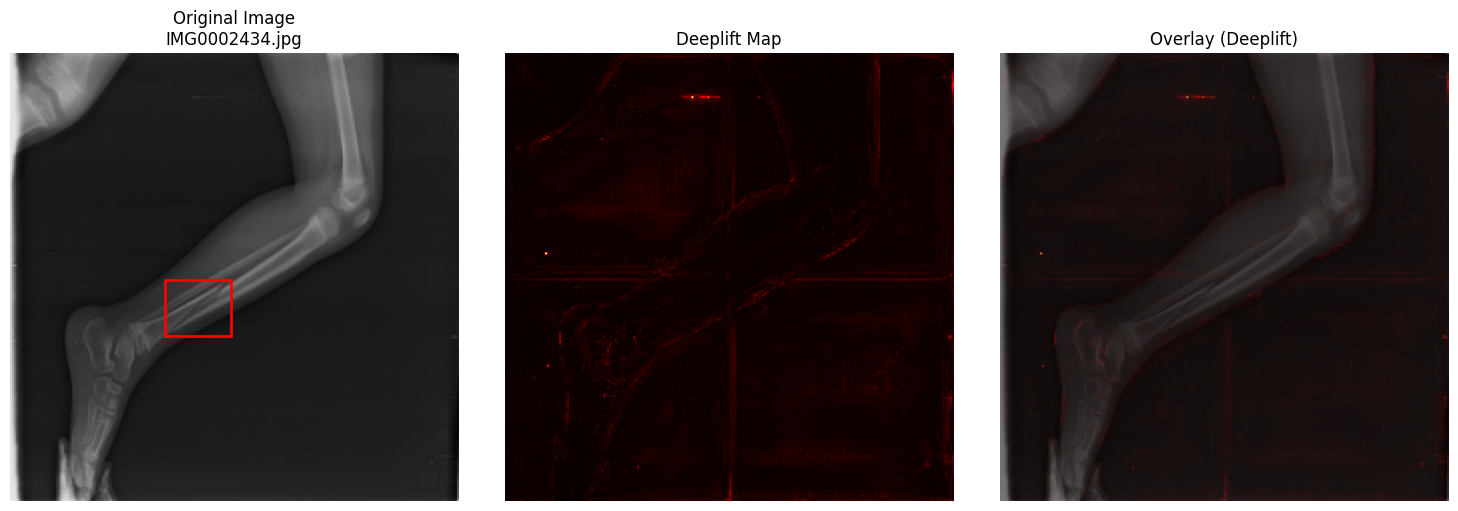

In [46]:
show_attribution_with_box(model, dataset, idx=290, method='deeplift')

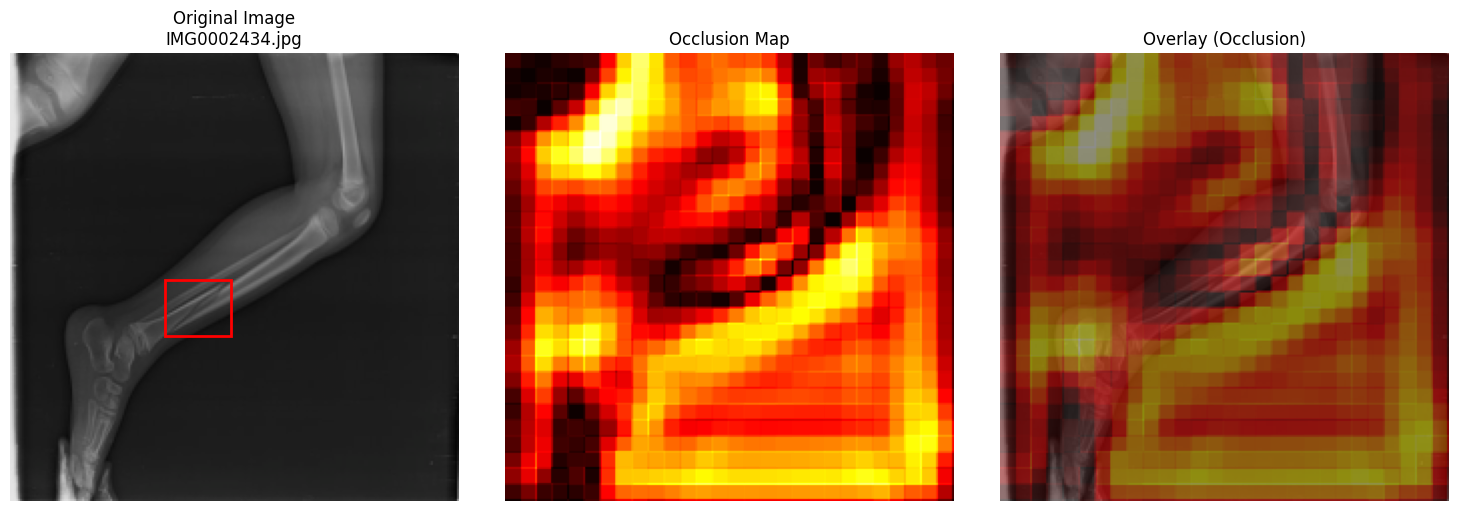

In [47]:
show_attribution_with_box(model, dataset, idx=290, method='occlusion')